# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

# Game of Life implementation

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from IPython.display import Image
from scipy import optimize

To implement the Conway's Game of Life we start with an initial configuration (seed) stored in a grid as a multidimensional numpy array.
At each time step the `update()` function is called to update the grid applying the GoF rules.
This function handles all the logic of the game and it's built to allow us to run some analysis on the evolution of the game.

Many different types of patterns occur in GoF, the most common are classified according to their behaviour and can be found [here](https://conwaylife.com/patterns/).
In particular we use `loadPattern()` function to import particular patterns we want to study, sparing us the time to manually implement them.

Finally, we store all the generated frames in ``.gif`` file to show the final result.

In [22]:
# Parameters
ON = 255  # Alive cell value
OFF = 0   # Dead cell value

n_steps = 50 # Number of steps done in the game
inter = 100  # Time in ms between each frame (step of the game) in the GIF


def update(frame_num, img, grid, initial_grid=None, period=None, occupancy=None, heat=None):
    """
    Update the grid applying the GoF rules.
    This function takes a numpy array representing the current generation at a specific step (time).
    If initial_grid and period arguments are passed, it checks if the new computed configuration is equal to the starting one, 
    keeping track of when it happens.
    If occupancy argument is passed, it calculate how many cells are alive at current step.
    If the heat argument is passed, it computes the difference in occupancy between current grid and updated grid.
    
    Parameters
    ----------
    frame_num : Current step number
    img : Input image
    grid : Current generation
    initial_grid : Initial generation
    period : List of flags: i-th element is 1 if the pattern has returned to original configuration at current step 0 otherwise
    occupancy : List of numbers of alive cells at each step
    heat : List of numbers of cells that changed state at each step
    
    Returns
    -------
    img : Output image
    """
    
    # Create a new grid for future state
    newGrid = grid.copy()

    # Save the number of rows and columns
    Nr = grid.shape[0]
    Nc = grid.shape[1]
    
    for i in range(Nr):
        for j in range(Nc):
            # For each cell in the grid compute the number of neighbouring alive cells
            total = int((grid[i, (j-1)%Nc] + grid[i, (j+1)%Nc] +
                         grid[(i-1)%Nr, j] + grid[(i+1)%Nr, j] +
                         grid[(i-1)%Nr, (j-1)%Nc] + grid[(i-1)%Nr, (j+1)%Nc] +
                         grid[(i+1)%Nr, (j-1)%Nc] + grid[(i+1)%Nr, (j+1)%Nc]) / ON)

            # Any alive cell with fewer than two alive neighbours or more than three alive neighbours dies
            # (with two or three live neighbours lives).
            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
                    
            # Any dead cell with exactly three live neighbours becomes alive.
            else:
                if total == 3:
                    newGrid[i, j] = ON

    # Save new image
    img.set_data(newGrid)

    # Keep track of how many cells change state
    if heat is not None:
        heat.append(np.sum(np.not_equal(grid,newGrid)))

    # Check if the patterns has returned to original configuration or not
    if initial_grid is not None and period is not None:
        period.append(1 if np.array_equal(newGrid,initial_grid) else 0)

    # Count how many alive cells
    if occupancy is not None:
        occupancy.append(np.sum(newGrid == ON))

    # Update the grid
    grid[:] = newGrid[:]

    return img


def loadPattern(file_path, rows=None, columns=None, loc=(0,0)):
    """
    Load an initial pattern from file.
    Initial position and grid size can be specified.
 
    Parameters
    ----------
    file_path : Path to input pattern
    rows : Position along rows
    columns : Position along columns
    loc : Grid size
    
    Returns
    -------
    grid : initial pattern
    """

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Remove whitespaces and ignore lines starting with '!'
    lines = [line.strip() for line in lines if not line.startswith('!')]

    # Check if the number of rows and columns were specified
    if rows == None:
        rows = len(lines)
    if columns == None:
        columns = max(len(line) for line in lines) 
    
    # Pad shorter lines with zeros to make them equal in length
    max_length = max(len(line) for line in lines) 
    lines_padded = [line.ljust(max_length, '.') for line in lines]

    # Put the pattern in the grid
    grid = np.zeros((rows, columns))
    pattern = np.array([[0 if cell == '.' else 255 for cell in line] for line in lines_padded])
    
    # Check if the pattern fits in the grid
    if loc[0] > rows or loc[1] > columns:
        raise ValueError("Invalid location parameter")
    
    if loc[0] + pattern.shape[0] > rows or loc[1] + pattern.shape[1] > columns:
        raise ValueError("The pattern overflows the grid")
    
    grid[loc[0]:loc[0]+pattern.shape[0], loc[1]:loc[1]+pattern.shape[1]] = pattern
    
    return grid


def saveFrame(num_frame, img):
    """
    Save a specific frame of the game.
    
    Parameters
    ----------
    frame_num : Current step number
    img : Input image
    
    Returns
    -------
    img : Output image
    """
    
    plt.savefig(f'gof_frame_{num_frame:03d}.png', format='png')
    return img

Regarding the analysis, we mainly study the occupancy (how many alive cells there are at every step of the game), the heat (the number of cells that change state at each step), their averages and their period (if they are periodic).

For _Oscillators_ patterns, which return to their initial state after a finite number of steps we also analyise the period (the number of steps before going back to the original state).

Moreover, for _Spaceships_ patterns, we analyze the speed: the number of cells that it has been displaced by after it has gone through one period (the number of steps before returning to the original configuration but in different position).
Speeds are measured in reference to the speed of light, denoted by c, which is the fastest possible speed at which any effect can propagate.

In [23]:
def computePeriod(x):
    """
    Compute the period of a periodic sequence by analyzing the self-convolution 
    of the sequence obtained through the FFT.
    The period of a signal is the duration it takes for the signal to complete one cycle. 
    For a periodic signal, this corresponds to the interval between the first 
    minimum and the second minimum in the self-convolution.
    Source: https://stackoverflow.com/questions/49531952/find-period-of-a-signal-out-of-the-fft

    Parameters
    ----------
    x : input list
    
    Returns
    -------
    period : period of the input or -1 is the input is not periodic
    """
    
    # Remove DC component
    x = x - np.mean(x)

    # Compute real-valued FFT
    fft = np.fft.rfft(x)

    # Compute the self-convolution and normalize it
    # (If first element is zero then the sequence has period 1)
    selfconvol = np.fft.irfft(abs(fft))
    if selfconvol[0] == 0:
        return 1
    selfconvol = selfconvol / selfconvol[0]
    
    # Get ranges for min and max
    fmax = np.max(selfconvol[1:len(x)//2])
    fmin = np.min(selfconvol[1:len(x)//2])

    # Find the first minimum
    xstartmin = 1
    while selfconvol[xstartmin] > fmin + 0.2 * (fmax - fmin) and xstartmin < len(x) // 2:
        xstartmin += 1

    # Find the first maximum
    xstartmax = xstartmin
    while selfconvol[xstartmax] < fmin + 0.7 * (fmax - fmin) and xstartmax < len(x) // 2:
        xstartmax += 1

    # Find the second minimum
    xstartmin = xstartmax
    while selfconvol[xstartmin] > fmin + 0.2 * (fmax - fmin) and xstartmin < len(x) // 2:
        xstartmin += 1

    # The sequence is not periodic
    if xstartmax == xstartmin:
        return -1

    # Return the period
    return np.argmax(selfconvol[xstartmax:xstartmin]) + xstartmax


def analyseOccupancy(occupancy, check_freq=False):
    """
    Plot the evolution over time of the number of alive cells and the average.
    If specified compute also the period of the occupancy.

    Parameters
    ----------
    occupancy : List of alive cells at every step
    check_freq : Flag to compute the FFT of the input
    
    Returns
    -------
    avg_occ : average value of occupancy
    occ_period : period of the occupancy (if any)
    """
    
    n_occ = len(occupancy)

    # Compute the average of occupancy
    if n_occ > 0:
        avg_occ = round(np.sum(occupancy) / n_occ)
        
    # Plot occupancy and average value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_occ), occupancy, marker="o", label='Occupancy')
    ax.axhline(avg_occ,label='Avg. occupancy', color='r')
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('No. alive cells')
    
    plt.title('Occupancy vs time')
    plt.legend()
    plt.tight_layout()

    # Compute the period of occupancy
    if check_freq:
        occ_period = computePeriod(occupancy)

        return avg_occ, occ_period

    return avg_occ


def analyseHeat(heat, check_freq=False):
    """
    Plot the evolution over time of the number of cells that change state at each step and the average.
    If specified compute the period of the heat.

    Parameters
    ----------
    heat : List of number of cells that change state at every step
    check_freq : Flag to compute the FFT of the input

    Returns
    -------
    avg_heat : average value of heat
    heat_period : period of the heat (if any)
    """
    
    n_heat = len(heat)

    # Compute the average of heat
    if n_heat > 0:
        avg_heat = round(np.sum(heat) / n_heat)

    # Plot heat and average value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_heat), heat, marker="o", label='State changes')
    ax.axhline(avg_heat, label='Avg. state changes', color='r')
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('No. of state change')
    
    plt.title('No. cells that change state vs time')
    plt.legend()
    plt.tight_layout()

    # Compute the period of heat
    if check_freq:
        heat_period = computePeriod(heat)

        return avg_heat, heat_period

    return avg_heat

# Stochastic example
This and the next sections all have the same structure:
- Initialize the grid with a pattern (which usually is loaded from a file).
- Initialize the parameters we want to study, which can be any of: period, occupancy, heat and speed.
- Plot the first generation.
- Apply the animation function to the first generation to create the .gif, this function takes as input:
  - The starting figure
  - The update function with its parameters
  - The number of frames to generate
  - The interval in ms between each frame
  - An init function.
- Save and show the animation.

In this section we initialize the game with a random generatly seed and let it evolve.

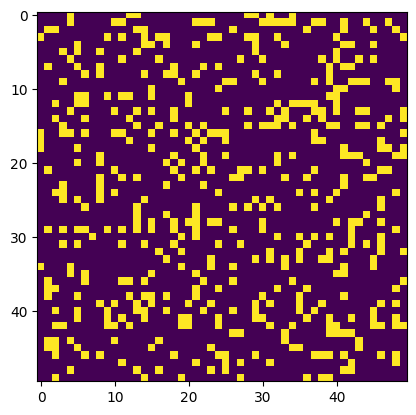

In [24]:
# Set the size of the grid
N = 50

# Generate a random grid
random_grid = np.random.choice([ON, OFF], N*N, p=[0.2, 0.8]).reshape(N, N)

# Original configuration
random_igrid = random_grid.copy() 

# List of period flags:
# 1 if the pattern returned to the original configuration at i-th step; 
# 0 otherwise
random_period = []

# How many alive cells at each step
random_occupancy = []

# How many cells change state at each step
random_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(random_grid, interpolation='nearest')
plt.plot()

# Set up the animation and save the first frame
random_out = animation.FuncAnimation(fig, 
                            partial(update, img = img, grid = random_grid, initial_grid = random_igrid, 
                                    period = random_period, occupancy = random_occupancy, heat = random_heat),
                            frames = n_steps, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [25]:
# Save and show animation
gif_name = 'random_example.gif'
random_out.save(gif_name, writer = 'pillow', fps = 5)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
Once we have obtained all the generations, we can study the evolution over time.

The average number of alive cells is 242
The occupancy is not periodic


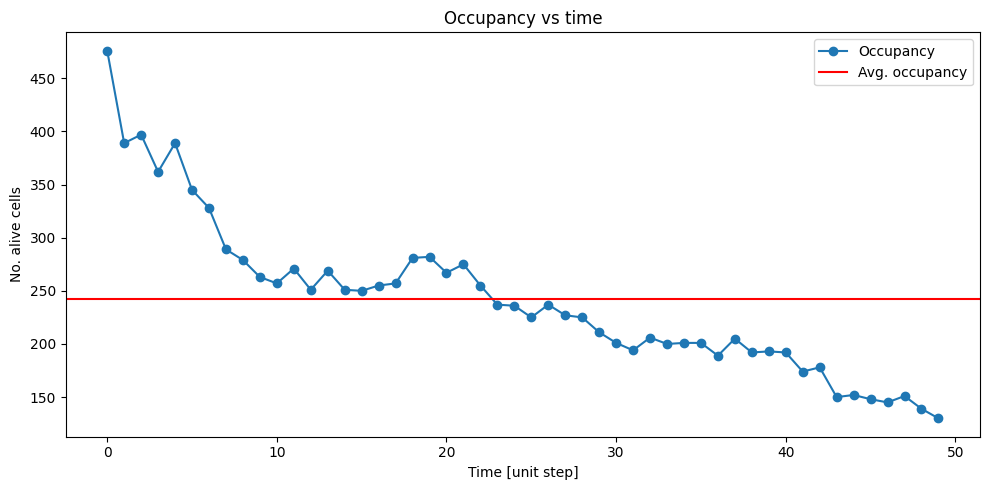

In [26]:
avgocc_random, periodocc_random = analyseOccupancy(random_occupancy, True)

print("The average number of alive cells is", avgocc_random)
if periodocc_random > 0:
    print('The number of alive cells has period', periodocc_random)
else:
    print('The occupancy is not periodic')

The average number of cells that change state at each generation is 202
The heat is not periodic


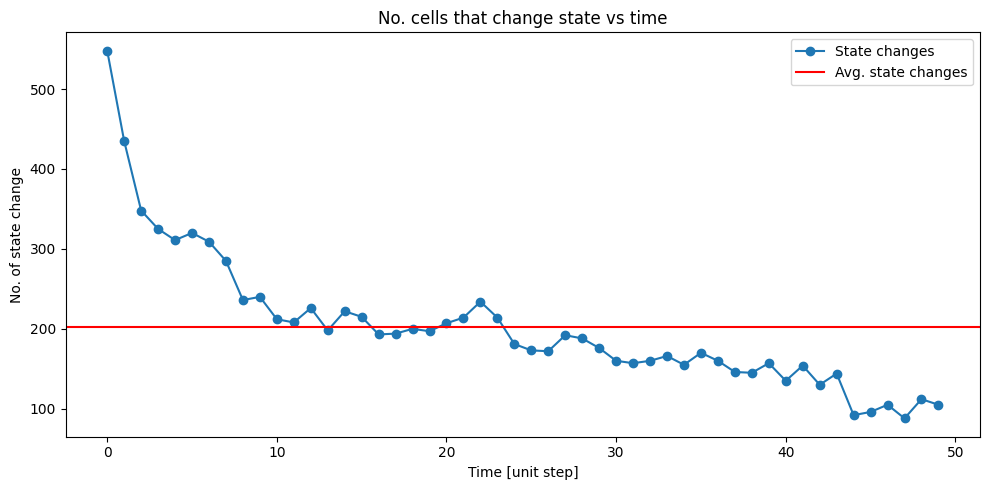

In [27]:
heat_random, periodheat_random = analyseHeat(random_heat, True)

print("The average number of cells that change state at each generation is", heat_random)
if periodheat_random > 0:
    print('The number of alive cells has period', periodheat_random)
else:
    print('The heat is not periodic')

In [28]:
if any(random_period):
    print('The pattern is periodic with period', computePeriod(random_period))
else:
    print('The pattern is not periodic')

The pattern is not periodic


# Still life example
A _Still life_ is a pattern that does not change from one step to the next.
Specifically we start the game with a seed called _Beehive at loaf_.<br>
As its name suggest, with this seed the game doesn't evolve: the alive cells are always the same both in number and in location, it's an equilibrium point.

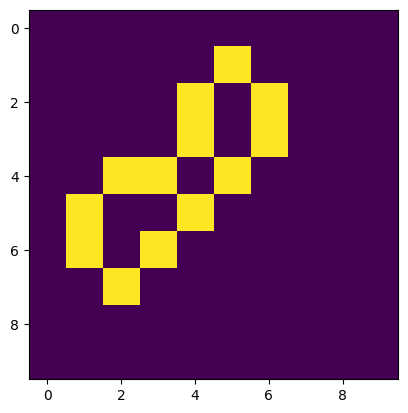

In [29]:
# Load pattern from file.
still_pattern = 'beehiveatloaf.cells.txt'
still_grid = loadPattern(still_pattern, 10, 10, (1, 1))

# Original configuration
still_igrid = still_grid.copy() 

# List of period flags:
# 1 if the pattern returned to the original configuration at i-th step; 
# 0 otherwise
still_period = []

# How many alive cells at each step
still_occupancy = []

# How many cells change state at each step
still_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(still_grid, interpolation='nearest')
plt.plot()

# Set up the animation and save the first frame
still_out = animation.FuncAnimation(fig, partial(update, img=img, grid=still_grid, initial_grid = still_igrid, 
                            period = still_period, occupancy=still_occupancy, heat=still_heat),
                            frames=n_steps, interval=inter,
                            init_func=lambda: saveFrame(0, img))

In [30]:
# Save and show animation
gif_name = 'beehiveatloaf.gif'
still_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
As expected the occupancy is constant over time and no cell change state at each step.

Note that still life patterns are said to have period 1, since they go back to the original configuration at each step.

The average number of alive cells is 13
The number of alive cells has period 1


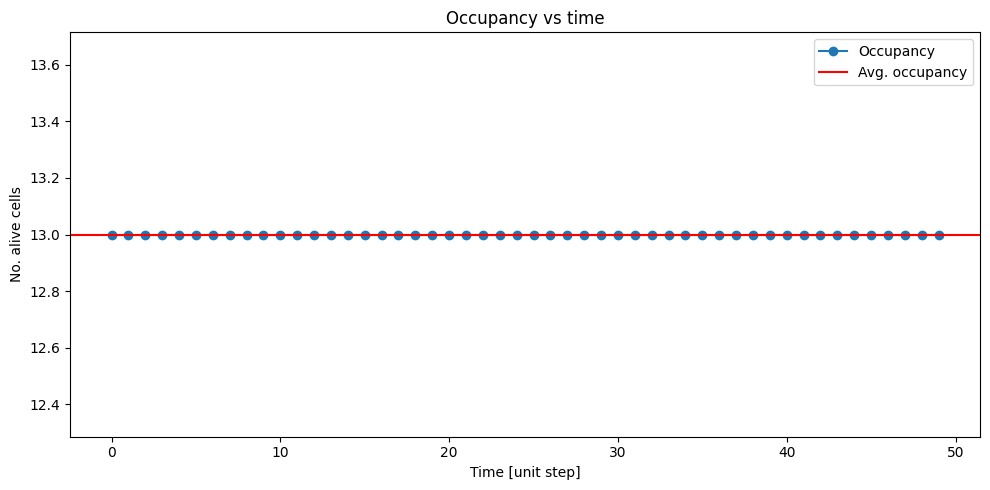

In [31]:
avgocc_still, periodocc_still = analyseOccupancy(still_occupancy, True)
print("The average number of alive cells is", avgocc_still)
print('The number of alive cells has period', periodocc_still)

The average number of cells that change state at each generation is 0
The average number of cells that change state at each generation has period 1


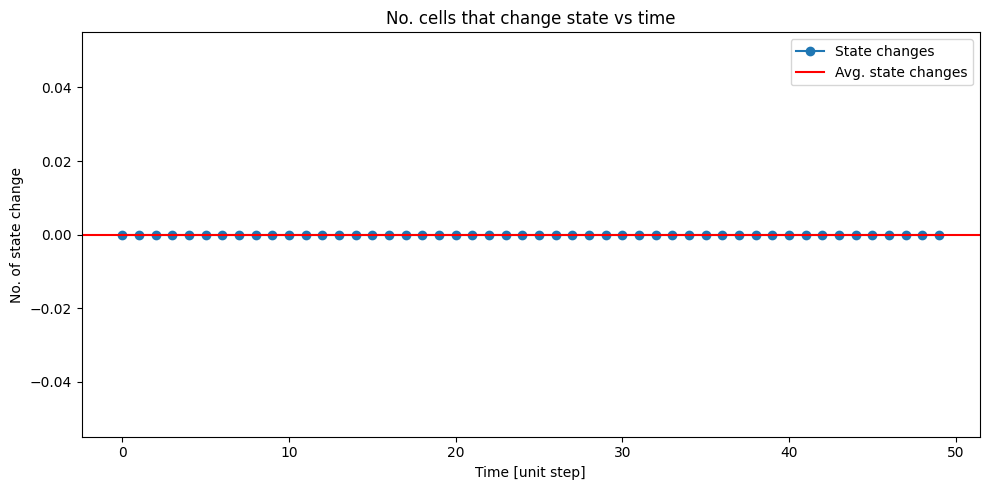

In [32]:
heat_still, periodheat_still = analyseHeat(still_heat, True)
print("The average number of cells that change state at each generation is", heat_still)
print("The average number of cells that change state at each generation has period", periodheat_still)

In [33]:
print('The pattern is periodic with period', computePeriod(still_period))

The pattern is periodic with period 1


# Spaceship example
A _Spaceship_ is a pattern which reappears after a certain number of steps in the same orientation but in a different position.
In this section we start with a particular pattern called _Big Glider_.
It was the first known diagonal spaceship.

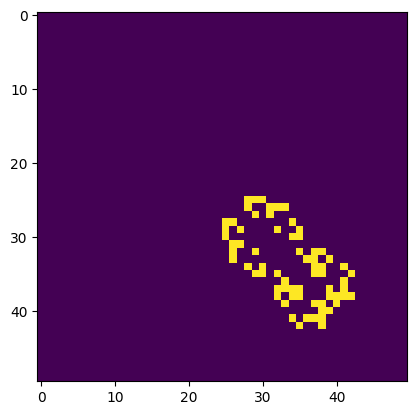

In [34]:
# Load patterns from file
glider_pattern = 'bigglider.cells.txt'
glider_grid = loadPattern(glider_pattern, 50, 50, (25,25))

# How many alive cells at each step
glider_occupancy = []

# How many cells change state at each step
glider_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(glider_grid, interpolation='nearest')
plt.plot()

# Set up the animation
glider_out = animation.FuncAnimation(fig, partial(update, img = img, grid = glider_grid, 
                                                  occupancy = glider_occupancy, heat = glider_heat),
                            frames = n_steps, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [35]:
# Save and show animation
gif_name = 'bigglider.gif'
glider_out.save(gif_name, writer='pillow', fps=4)


Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
By definition of spaceships patterns, the occupancy and the heat are periodic with the same period.
This fact is shown by the following plots.

Moreover, the speed of this spaceship can be easily compute as the inverse of the occupancy period.

The average number of alive cells is 67
The number of alive cells has period 4


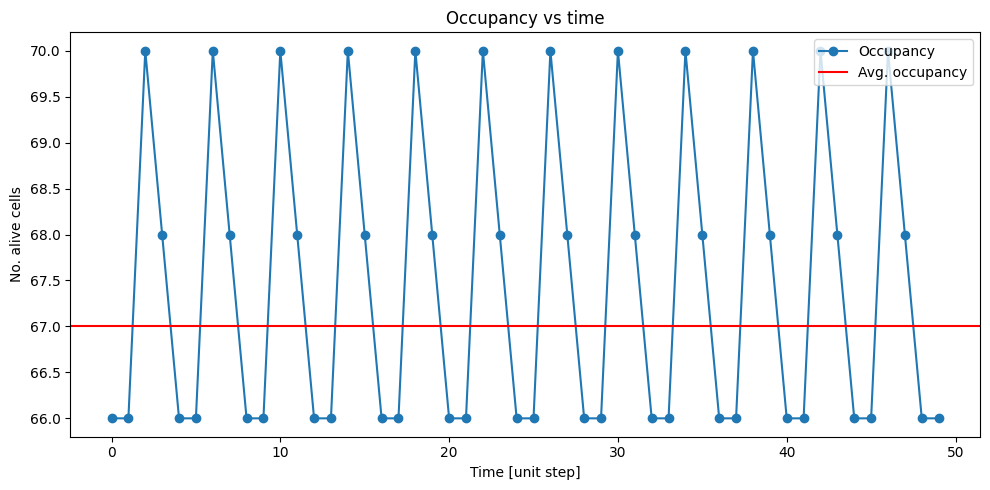

In [36]:
avgocc_glider, periodocc_glider = analyseOccupancy(glider_occupancy, True)
print("The average number of alive cells is", avgocc_glider)
print('The number of alive cells has period', periodocc_glider)

The average number of cells that change state at each generation is 61
The average number of cells that change state at each generation has period 4


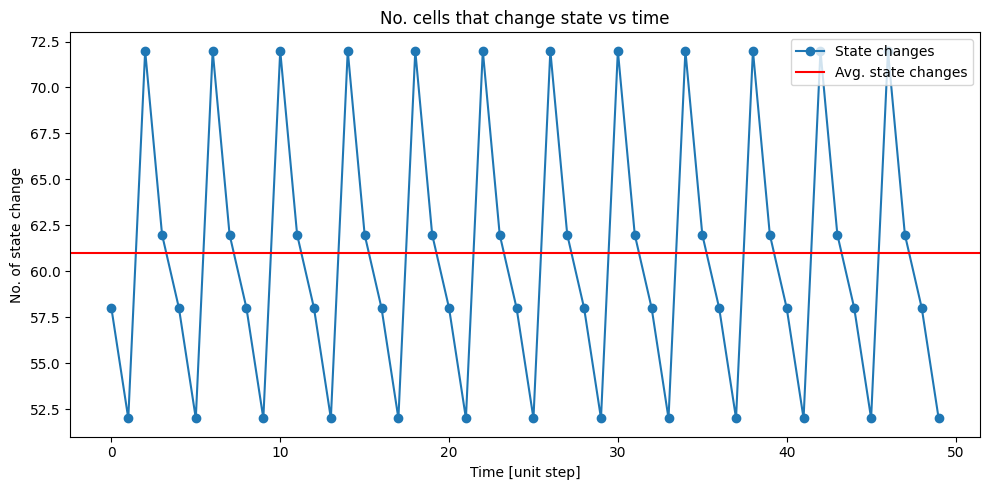

In [37]:
heat_glider, periodheat_glider = analyseHeat(glider_heat, True)
print("The average number of cells that change state at each generation is", heat_glider)
print("The average number of cells that change state at each generation has period", periodheat_glider)

In [38]:
print(f"This spaceship has speed (1/{periodocc_glider})*c")

This spaceship has speed (1/4)*c


# Oscillator example
An _Oscillator_ is a pattern that returns to its original state, in the same orientation and position, after a finite number of steps.
The smallest number of generations it takes before the pattern returns to its initial condition is called the period of the oscillator.

In this section we study a pattern called Koksgalaxy, which has period 8.

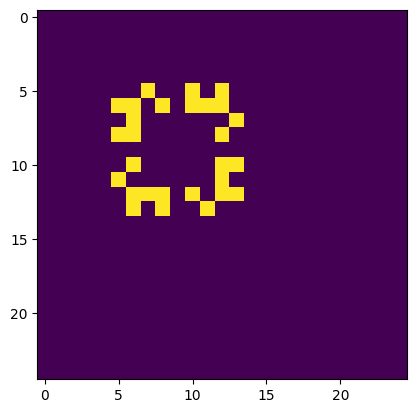

In [39]:
# Load patterns from file.
koksgalaxy = 'koksgalaxy.cells.txt'
koksgalaxy_grid = loadPattern(koksgalaxy, 25,25, (5,5))

# Original configuration
koksgalaxy_igrid = koksgalaxy_grid.copy() 

# List of period flags:
# 1 if the pattern returned to the original configuration at i-th step; 
# 0 otherwise
koksgalaxy_period = []

# How many alive cells at each step
koksgalaxy_occupancy = []

# How many cells change state at each step
koksgalaxy_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(koksgalaxy_grid, interpolation='nearest')
plt.plot()

# Set up the animation
koksgalaxy_out = animation.FuncAnimation(fig, 
                            partial(update, img = img, grid = koksgalaxy_grid, initial_grid = koksgalaxy_igrid, 
                                    period = koksgalaxy_period, occupancy = koksgalaxy_occupancy, heat = koksgalaxy_heat),
                            frames = n_steps, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [40]:
# Save and show animation
gif_name = 'koksgalaxy_out.gif'
koksgalaxy_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
Being this pattern periodic, it must follow that the occupancy and heat have the same period which has to be equal to the period of the pattern.

This fact is confirmed by the following plots.

The average number of alive cells is 41
The number of alive cells has period 8


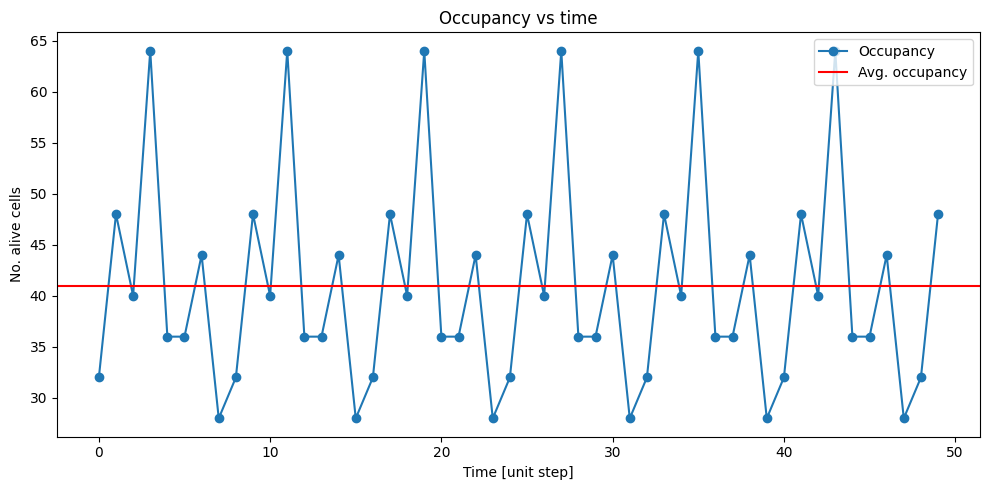

In [41]:
avgocc_koksgalaxy, periodocc_koksgalaxy = analyseOccupancy(koksgalaxy_occupancy, True)
print("The average number of alive cells is", avgocc_koksgalaxy)
print('The number of alive cells has period', periodocc_koksgalaxy)

The average number of cells that change state at each generation is 38
The average number of cells that change state at each generation has period 8


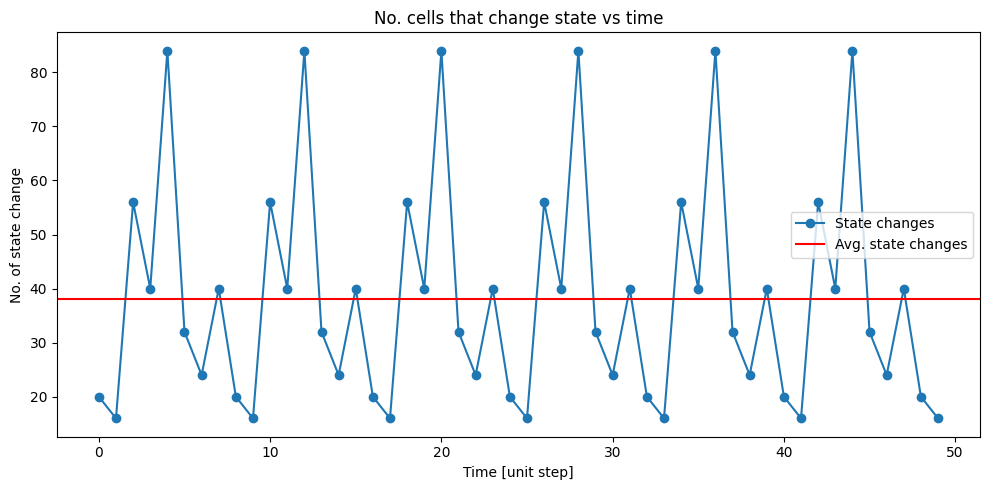

In [42]:
heat_koksgalaxy, periodheat_koksgalaxy = analyseHeat(koksgalaxy_heat, True)
print("The average number of cells that change state at each generation is", heat_koksgalaxy)
print("The average number of cells that change state at each generation has period", periodheat_koksgalaxy)

In [43]:
print('The pattern is periodic with period', computePeriod(koksgalaxy_period))

The pattern is periodic with period 8


# Quadratic growth pattern
A quadratic growth is a pattern which can grow indefintely with a rate proportional to t^2, where t is the number of steps that a pattern has been run.

In this section we study the Teeth pattern, one of the smallest patterns with quadratic growth.

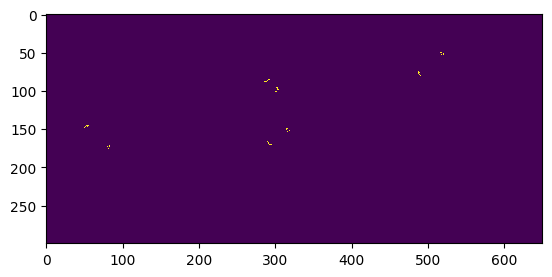

In [326]:
# Load patterns from file.
teeth = 'teeth.cells.txt'
teeth_grid = loadPattern(teeth, 300,650, (50,50))

# How many alive cells at each step
teeth_occupancy = []

# How many cells change state at each step
teeth_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(teeth_grid, interpolation='nearest')
plt.plot()

# Set up the animation
teeth_out = animation.FuncAnimation(fig, 
                            partial(update, img = img, grid = teeth_grid,
                                    occupancy = teeth_occupancy, heat = teeth_heat),
                            frames = 1000, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [327]:
# Save and show animation
gif_name = 'teeth.gif'
teeth_out.save(gif_name, writer='pillow', fps=60)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
We let it run for 1000 steps, enabling us to observe the quadratic growth of occupancy.
To achieve this, we employed a quadratic fit which gives us a high accuracy.

Moreover, we can observe that also the heat increases with time.
We also in this case employed a quadratic fit which in this case gives a slightly lower accuracy.

The average number of alive cells is 1570
Goodness of quadratic fit: 95.89%


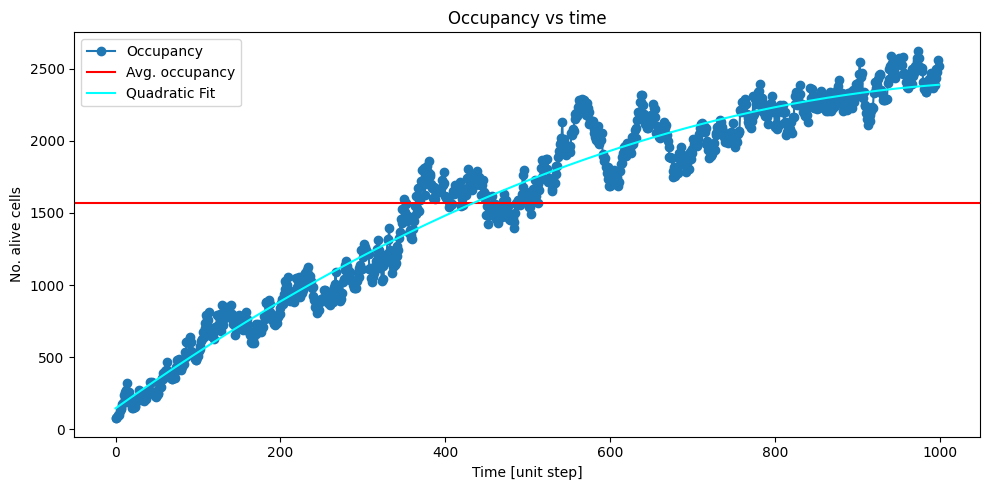

In [341]:
avgocc_teeth = analyseOccupancy(teeth_occupancy)
print("The average number of alive cells is", avgocc_teeth)

# Fit quadratic function
def f(x, a, b, c):
    return a * x**2 + b * x + c

x = np.arange(len(teeth_occupancy))
popt, _ = optimize.curve_fit(f, x, teeth_occupancy, full_output=False)

a_fit, b_fit, c_fit = popt
y_fit = f(x, a_fit, b_fit, c_fit)

# Check the goodnes of fit
y_hat = f(np.arange(len(teeth_occupancy)), a_fit, b_fit, c_fit)

ssr = np.sum((y_hat - teeth_occupancy)**2)
tss = np.sum((np.mean(y_hat) - teeth_occupancy)**2)

rsq = 1 - ssr / tss
print(f"Goodness of quadratic fit: {rsq*100:.2f}%")

plt.plot(x, y_fit, label='Quadratic Fit', color='cyan')
plt.legend()
plt.show()

The average number of cells that change state at each generation is 1039
Goodness of quadratic fit: 87.65%


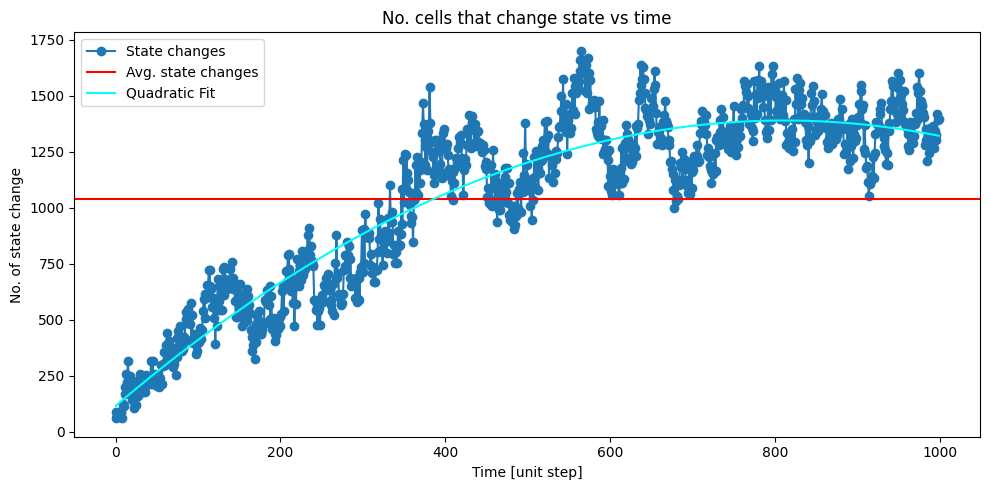

In [340]:
heat_teeth = analyseHeat(teeth_heat)
print("The average number of cells that change state at each generation is", heat_teeth)

# Fit quadratic function
def f(x, a, b, c):
    return a * x**2 + b * x + c

x = np.arange(len(teeth_heat))
popt, _ = optimize.curve_fit(f, x, teeth_heat, full_output=False)

a_fit, b_fit, c_fit = popt
y_fit = f(x, a_fit, b_fit, c_fit)

# Check the goodnes of fit
y_hat = f(np.arange(len(teeth_heat)), a_fit, b_fit, c_fit)

ssr = np.sum((y_hat - teeth_heat)**2)
tss = np.sum((np.mean(y_hat) - teeth_heat)**2)

rsq = 1 - ssr / tss
print(f"Goodness of quadratic fit: {rsq*100:.2f}%")

plt.plot(x, y_fit, label='Quadratic Fit', color='cyan')
plt.legend()
plt.show()